# 1. Import libraries and data 

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import random
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# import functions from the project

#get_path = os.path.abspath("")
project_path = 'd:\\PYTHON\\CS_Bootcamp\\programs\\cs-intrusion-detection-system'

# add path to load own functions from .py files in scrips folder
sys.path.insert(0, project_path + '\scripts')

from preprocessing import *
from plotting import *

In [3]:
# get data 
file_name_train_data = "KDDTrain+.txt"
file_name_test_tata = "KDDTest+.txt"

# column names
column_names = [
    "duration",
    "protocol_type",
    "service",
    "flag",
    "src_bytes",
    "dst_bytes",
    "land",
    "wrong_fragment",
    "urgent",
    "hot",
    "num_failed_logins",
    "logged_in",
    "num_compromised",
    "root_shell",
    "su_attempted",
    "num_root",
    "num_file_creations",
    "num_shells",
    "num_access_files",
    "num_outbound_cmds",
    "is_host_login",
    "is_guest_login",
    "count",
    "srv_count",
    "serror_rate",
    "srv_serror_rate",
    "rerror_rate",
    "srv_rerror_rate",
    "same_srv_rate",
    "diff_srv_rate",
    "srv_diff_host_rate",
    "dst_host_count",
    "dst_host_srv_count",
    "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate",
    "dst_host_srv_serror_rate",
    "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate",
    "attack_type",
    "difficulty_level"
]

# load data as df
train_data = pd.read_csv("../data/"+ file_name_train_data,  names=column_names)
test_data = pd.read_csv("../data/"+ file_name_test_tata, names=column_names)

print(train_data.shape)
print(test_data.shape)

(125973, 43)
(22544, 43)


# 2. Preprocessing
1. Recode categorical features to category
2. Recode numerical features to binary category (based on EDA)
3. Recode numerical features to three categories (based on EDA)
4. Create binary target variable (attack: 0,1)

- Other numerical features are not further processed (**NUM_FEATURES**)
- all processed categorical features are added to **CAT_FEATURES**


In [4]:
# features to process 
NUM_FEATURES = set([
    'srv_serror_rate',
    'same_srv_rate',
    'dst_host_same_srv_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_count',
    'duration',
    'src_bytes',
    'dst_host_diff_srv_rate',
    'dst_host_srv_serror_rate',
    'dst_host_serror_rate',
    'srv_count',
    'dst_host_srv_rerror_rate',
    'dst_bytes',
    'dst_host_srv_count',
    'serror_rate',
    'diff_srv_rate',
    'dst_host_same_src_port_rate',
    'srv_diff_host_rate',
    'srv_rerror_rate',
    'dst_host_rerror_rate',
    'rerror_rate',
    'count'])

CAT_FEATURES = set(['logged_in', 'root_shell', 'is_guest_login', 'land', 'flag', 'difficulty_level', 'protocol_type', 'service'])

# features for recoding
to_recode_2_cat = ['num_shells',
                    'urgent',
                    'num_root',           # --> works with threshold .99
                    'num_file_creations',
                    'num_failed_logins',
                    'su_attempted',
                    'num_access_files',
                    'wrong_fragment',     # --> works with threshold .99
                    ]

# unfortunatelly hardcoded boundaries for now: 
to_recode_3_cat = {'num_compromised': 10, 
                       'hot': 5} 
condition_labels = ["none", "low", "high"] 


# recode to binary target variable (attack vs no attack)
target_feature = "attack_type" 

In [5]:
# 1. convert categorical features to categories 
for feature in list(CAT_FEATURES):
    train_data = convert_column_type(train_data, feature, 'category' )
    test_data = convert_column_type(test_data, feature, 'category' )


In [6]:
# 2. recode numerical to binary categorical features 
for feature in to_recode_2_cat:
    new_feature_name = feature + "_cat"
    recode_to_binary_feature(train_data, feature, new_feature_name)
    recode_to_binary_feature(test_data, feature, new_feature_name, threshold=0) # don't use the threshold here

    # add recoded features to CAT_FEATURES 
    if is_categorical_dtype(train_data, new_feature_name) & is_categorical_dtype(
        test_data, new_feature_name):
        # add only when both successfully transformed 
        CAT_FEATURES.add(new_feature_name)
    else:
        print(f"Feature {new_feature_name} not added, check processing.")

In [7]:
# 3. recode numerical features to 3 category features

for feature, bound in to_recode_3_cat.items(): 
    cond_train = get_conditions(train_data, feature, bound)
    cond_test = get_conditions(test_data, feature, bound)
    new_feature_name = feature +"_cat"

    recode_to_categories(train_data, new_feature_name, cond_train, condition_labels)
    recode_to_categories(test_data, new_feature_name, cond_test, condition_labels)

    # add recoded features to CAT_FEATURES 
    if is_categorical_dtype(train_data, new_feature_name) & is_categorical_dtype(
        test_data, new_feature_name):
        # add only when both successfully transformed 
        CAT_FEATURES.add(new_feature_name)
    else:
        print(f"Feature {new_feature_name} not added, check processing.")


In [8]:
# 4. recode target feature 

recode_binary_target_feature(train_data, target_feature, "attack")
recode_binary_target_feature(test_data, target_feature, "attack")

if is_categorical_dtype(train_data, "attack") & is_categorical_dtype(
        test_data, "attack"):
    print("New target variable created succsessfully.")
else:
    print("Something went wrong with the target variable!")



New target variable created succsessfully.


In [9]:
# we have now done the preprocessing for all features
numerical_features = list(NUM_FEATURES)
categorical_features = list(CAT_FEATURES)

print(f"There are {len(numerical_features)} numerical and {len(categorical_features)} categorical features.")

There are 22 numerical and 18 categorical features.


In [10]:
numerical_features

['dst_host_srv_serror_rate',
 'count',
 'dst_host_serror_rate',
 'dst_host_diff_srv_rate',
 'diff_srv_rate',
 'dst_host_same_src_port_rate',
 'srv_count',
 'srv_rerror_rate',
 'dst_host_count',
 'serror_rate',
 'srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_srv_rerror_rate',
 'duration',
 'srv_diff_host_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_bytes',
 'src_bytes',
 'rerror_rate',
 'same_srv_rate']

In [11]:
# TODO: further export the preprocessing functionality

In [12]:
# define data

X_train = train_data[numerical_features + categorical_features]
y_train = train_data["attack"]

X_test = test_data[numerical_features + categorical_features]
y_test = test_data["attack"]

print('X_train dimensions:', X_train.shape)
print('X_test dimensions:', X_test.shape)
print('y_train dimensions:', y_train.shape)
print('y_test dimensions:', y_test.shape)

X_train dimensions: (125973, 40)
X_test dimensions: (22544, 40)
y_train dimensions: (125973,)
y_test dimensions: (22544,)


In [13]:
# define simple baseline models 

def model_genuine_prediction(data):
    """ 
    Baseline model 1. 
    Always predict 'genuine' = 0 network traffic.
    """
    return np.zeros(data.shape[0])

def model_random_prediction(data):
    """ 
    Baseline model 2.
    Randomly predict 'malicious' = 1 or 'genuine' = 0 network traffic. 
    """
    return [random.randint(0 ,1) for _ in range(data.shape[0])]

def model_risky_protocol_prediction(data):
    """ 
    Baseline model 3.
    When the protocol type is 'icmp' predict the network traffic is 'malicious' = 1.
    EDA revealed that over 80% of traffic with 'icmp protocol type was malicious.
    """
    return [1 if protocol == 'icmp' else 0 for protocol in data["protocol_type"]]


In [14]:
# make predictions usinge baseline models 
m1_train_pred = model_genuine_prediction(X_train)
m1_test_pred = model_genuine_prediction(X_test)

m2_train_pred = model_random_prediction(X_train)
m2_test_pred = model_random_prediction(X_test)

m3_train_pred = model_risky_protocol_prediction(X_train)
m3_test_pred = model_risky_protocol_prediction(X_test)


In [ ]:
# evaluation 
def model_evaluation(y_test, y_pred): 
    # quick and dirty evaluation output for now 
    # prevent classification report warning with adding 'zero_division=0', 
    # in case model does not predict one class -> 0 instead of NaN
    print("------"*10)
    print("Classification Report: \n", 
          classification_report(y_test, y_pred))
    print("------"*10)
    cr = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    #f1_score = cr['macro avg']['f1-score'] * 100
    #print(f"F1_Score: {round(f1_score,0)}") 
    return cr

def plot_confusion_matrix(y_test, y_pred):
   
    # get matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    # create labels
    group_names = ["TN", "FP", "FN", "TP" ] #v1
    gc = [value for value in cf_matrix.flatten()]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()] # v2
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)] #v3
    labels = [f"{v1}\n{v2}\n{v3} "for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    # same shape as cf matrix
    labels = np.asarray(labels).reshape(2,2)
    
    # dict to calculate metrics 
    v_dict = dict(zip(group_names,gc))
    
    # accuracy
    accuracy = (v_dict["TP"] + v_dict["TN"]) / (v_dict["TP"] + v_dict["FN"] + v_dict["TN"] + v_dict["FP"])
    print(f"Accuracy  {round(accuracy*100,2)}%  --> Proportion of all classifications (attack and no attack) that were correct.")
    
    # precision
    if (v_dict["TP"] + v_dict["FP"]) == 0: # avoid nan when 0 division
        precision = 0.0   
    else:
        precision = v_dict["TP"] / (v_dict["TP"] + v_dict["FP"])
    print(f"Precision {round(precision*100,2)}%  --> Correctness: proportion of attack detections that were correct.")
    # Precision = Correctness: quality of positive predictions, (does not accout for correct detection of no attack - TN)!
    # Precision improves when false positives decrease 
    # Solution: INCREASE threshold for classification --> less false pos but more false neg (bad for recall)
     
    # recall
    recall = v_dict["TP"]/(v_dict["TP"]+v_dict["FN"])
    print(f"Recall    {round(recall*100,2)}%  --> Sensitivity (TPR): proportion of actual attacks that could be correctly identified.")
    #  recall = models ability to detect attacks correctly (does not account for falase alarms!)
    #  recall = probabaility of detection
    #  Recall improves when false negatives decrease
    #  Solution: DECREASE the threshold for classification --> less false negatives, but more false positives (bad for precision)

    # precision-recall-tradeoff (you only optimize for one, because impoving one, makes the other worse)
    # depending on case --> decide for the measure to optimize 
    
    # you can either be PRECISE and be CAREFUL that attact predictions are correct --> high risk of missing actual attacks (High threshold)
    # or you can make sure to be SENSITIVE and detect as much attacks as possible --> high risk of False Alarms (FPR) (LOW TRESHOLD)
    # FPR = proportion of actual negatives that wee incorrecly classified as attacks
    # the plot 
    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap="Blues")
    ax.set(xlabel="Predicted", ylabel="True")
    return accuracy, precision, recall
    

Accuracy  53.46%  --> Proportion of all classifications (attack and no attack) that were correct.
Precision 0.0%  --> Correctness: proportion of attack detections that were correct.
Recall    0.0%  --> Sensitivity (TPR): proportion of actual attacks that could be correctly identified.


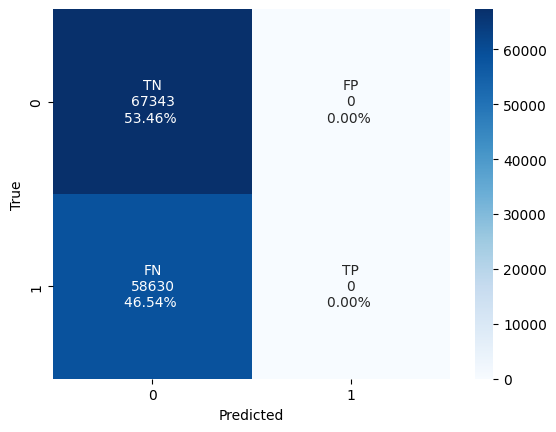

In [63]:
a, p, r = plot_confusion_matrix(y_train, m1_train_pred)

In [59]:
m32_train_eval = model_evaluation(y_train, m3_train_pred)
#m1_test_eval = model_evaluation(y_test, test_prediction)

------------------------------------------------------------
Classification Report: 
               precision    recall  f1-score   support

           0       0.56      0.98      0.71     67343
           1       0.84      0.12      0.21     58630

    accuracy                           0.58    125973
   macro avg       0.70      0.55      0.46    125973
weighted avg       0.69      0.58      0.48    125973

------------------------------------------------------------


In [56]:
(.84+0.56)/2

0.7